# LUNA Dataset Preprocessing Visualization

This notebook visualizes the preprocessing pipeline for the LUNA dataset used in feature extraction.

In [8]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from evaluation.luna_extractor import LunaFeatureExtractor

from models import get_transforms, plot_3d_image
import monai

## Load LUNA Dataset

In [9]:
# Initialize extractor to get data splits
extractor = LunaFeatureExtractor()
train_df = extractor.get_split_data('train')
print(f"Training samples: {len(train_df)}")
train_df.head()

Training samples: 338


,Unnamed: 0.1,Unnamed: 0,malignancy,coordX,coordY,coordZ,image_path
0,170,288,0,100.546875,-2.306244,-129.250000,/mnt/data1/suraj/RadiomicsFoundationModel/LUNA...
1,405,720,1,-97.714848,-87.589848,1131.699996,/mnt/data1/suraj/RadiomicsFoundationModel/LUNA...
2,525,896,0,-116.556641,227.519534,-565.300049,/mnt/data1/suraj/RadiomicsFoundationModel/LUNA...
3,605,1042,0,120.191406,-124.105469,-183.200004,/mnt/data1/suraj/RadiomicsFoundationModel/LUNA...
4,526,897,0,-108.769531,-123.917969,-105.500006,/mnt/data1/suraj/RadiomicsFoundationModel/LUNA...


## Preprocessing Pipeline Visualization

Let's visualize each step of the preprocessing pipeline for a sample image:

Original image shape: torch.Size([1, 512, 512, 95])


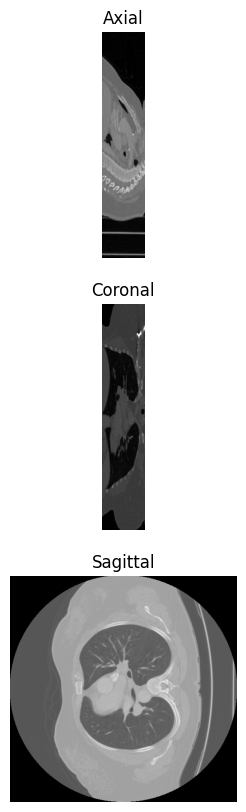

In [10]:
# Get sample image
sample_row = train_df.iloc[0]

# Create individual transforms to visualize each step
load_transform = monai.transforms.Compose([
    monai.transforms.LoadImage(ensure_channel_first=True, reader="ITKReader")
])

# Load original image
original_image = load_transform(sample_row['image_path'])
print("Original image shape:", original_image.shape)
plot_3d_image(original_image)

### Step 1: Orientation Normalization (LPS)

Oriented image shape: torch.Size([1, 512, 512, 95])


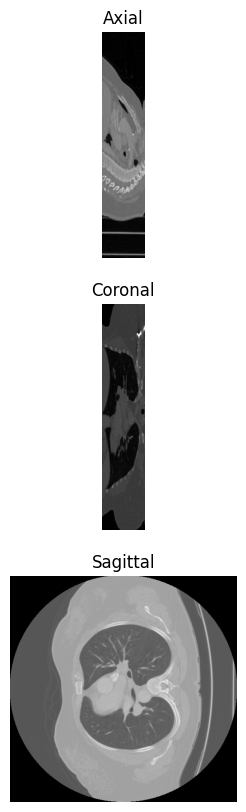

In [15]:
orient_transform = monai.transforms.Orientation(axcodes="LPS")
oriented_image = orient_transform(original_image)
print("Oriented image shape:", oriented_image.shape)
plot_3d_image(oriented_image)

### Step 2: Spacing Normalization

Normalized spacing image shape: torch.Size([1, 440, 440, 236])


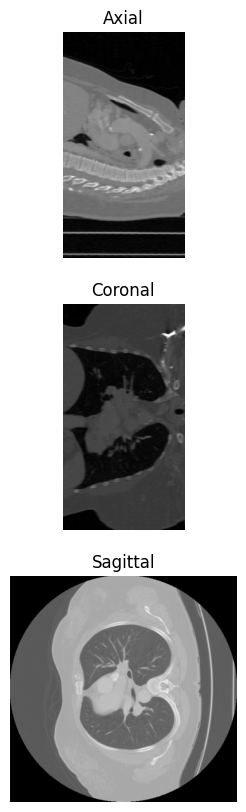

In [16]:
spacing_transform = monai.transforms.Spacing(
    pixdim=(1, 1, 1),
    padding_mode="zeros",
    mode="linear",
    align_corners=True
)
spaced_image = spacing_transform(oriented_image)
print("Normalized spacing image shape:", spaced_image.shape)
plot_3d_image(spaced_image)

### Step 3: Patch Extraction

Patched image shape: torch.Size([1, 48, 48, 48])


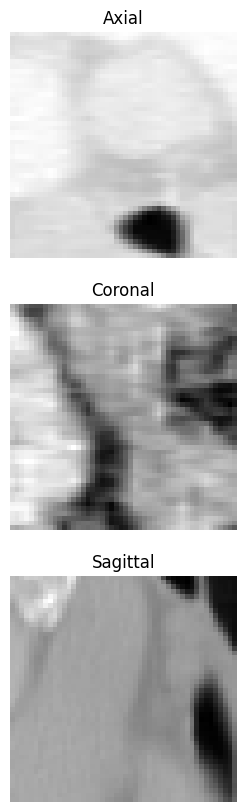

In [17]:
# Create data dictionary for patch extraction
data_dict = {"image": spaced_image, "image_path": sample_row['image_path']}

patch_transform = monai.transforms.Compose([
    monai.transforms.SpatialPad(spatial_size=(48, 48, 48)),
    monai.transforms.CenterSpatialCrop(roi_size=(48, 48, 48))
])

patched_image = patch_transform(data_dict["image"])
print("Patched image shape:", patched_image.shape)
plot_3d_image(patched_image)

### Step 4: Intensity Scaling

In [ ]:
scale_transform = monai.transforms.ScaleIntensityRange(
    a_min=-1024,
    a_max=2048,
    b_min=0,
    b_max=1,
    clip=True
)

scaled_image = scale_transform(patched_image)
print("Scaled image shape:", scaled_image.shape)
plot_3d_image(scaled_image)

## Complete Pipeline

Now let's look at the complete preprocessing pipeline using the provided transforms:

In [ ]:
# Get the full transform pipeline
full_transforms = get_transforms(
    orient="SPL",
    scale_range=(-1024, 2048),
    spatial_size=(48, 48, 48),
    spacing=(1, 1, 1)
)

# Create input dictionary
input_dict = {"image_path": sample_row['image_path']}

# Apply full transform
processed_image = full_transforms(input_dict)
print("Final processed image shape:", processed_image.shape)
plot_3d_image(processed_image)

## Batch Processing Visualization

Let's visualize preprocessed patches from multiple samples:

In [ ]:
# Process multiple samples
n_samples = 4
sample_rows = train_df.iloc[:n_samples]

fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))

for idx, row in enumerate(sample_rows.itertuples()):
    input_dict = {"image_path": row.image_path}
    processed = full_transforms(input_dict)
    
    # Plot axial slice
    axes[idx, 0].imshow(processed[:, processed.shape[1]//2, :, :].permute(1, 2, 0), cmap='gray')
    axes[idx, 0].set_title(f'Sample {idx+1} - Axial')
    axes[idx, 0].axis('off')
    
    # Plot coronal slice
    axes[idx, 1].imshow(processed[:, :, processed.shape[2]//2, :].permute(1, 2, 0), cmap='gray')
    axes[idx, 1].set_title(f'Sample {idx+1} - Coronal')
    axes[idx, 1].axis('off')
    
    # Plot sagittal slice
    axes[idx, 2].imshow(processed[:, :, :, processed.shape[3]//2].permute(1, 2, 0), cmap='gray')
    axes[idx, 2].set_title(f'Sample {idx+1} - Sagittal')
    axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()